Datasets used: 
- `LiptonDataset` :<br>This dataset consists of two features, hair length and
work experience, and supposes a binary classifier that uses these
features to decide whether a given person should be hired.

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt
from sklearn import preprocessing

from IPython.display import Markdown, display

In [2]:
random_seed = 131313
sensitive_attribute = "gender"
num_bins = 10

## Function to generate synthetic data used by Lipton et al. in arXiv:1711.07076

In [3]:
def generate_lipton(scale=True, num_pts=1000, seed=0):
    '''
    Synthetic data used by Lipton et al. in arXiv:1711.07076
    '''
    np.random.seed(seed)
    work_exp_m = np.random.poisson(31, size=num_pts) - np.random.normal(20, 0.2, size=num_pts)
    work_exp_f = np.random.poisson(25, size=num_pts) - np.random.normal(20, 0.2, size=num_pts)
    
    np.random.seed(seed+1)
    hair_len_m = 35 * np.random.beta(2, 7, size=num_pts)
    hair_len_f = 35 * np.random.beta(2, 2, size=num_pts)
    
    np.random.seed(seed+2)
    ym = np.random.uniform(size=num_pts) < 1 / (1 + np.exp(25.5 - 2.5*work_exp_m))
    yf = np.random.uniform(size=num_pts) < 1 / (1 + np.exp(25.5 - 2.5*work_exp_f))
    
    if scale: #scale the input attributes to zero mean and unit variance
        work_exp = np.concatenate((work_exp_m, work_exp_f))
        work_exp = preprocessing.scale(work_exp)
        work_exp_m = work_exp[:num_pts]
        work_exp_f = work_exp[num_pts:]
        hair_len = np.concatenate((hair_len_m, hair_len_f))
        hair_len = preprocessing.scale(hair_len)
        hair_len_m = hair_len[:num_pts]
        hair_len_f = hair_len[num_pts:]
    
    #combine the input attributes to create the input matrix
    Xm = np.stack((work_exp_m, hair_len_m), axis=1)
    Xf = np.stack((work_exp_f, hair_len_f), axis=1)
    columns = ['work_exp', 'hair_len']
    
    return Xm, Xf, ym, yf, columns

## Load Dataset

In [4]:
Xm, Xf, ym, yf, columns = generate_lipton(num_pts=10000)
Xm = pd.DataFrame(Xm,columns = columns)
Xf = pd.DataFrame(Xf,columns = columns)
Xm['labels'] = ym
Xf['labels'] = yf
Xm['labels'] = np.where((Xm['labels'] == True) , 1, 0)
Xf['labels'] = np.where((Xf['labels'] == True) , 1, 0)
Xm['gender'] = 'Male'
Xf['gender'] = 'Female'
df = pd.concat([Xm,Xf],ignore_index=True, sort=False)
df = df.sample(frac=1).reset_index(drop=True)

# df['work_exp'], cut_bin = pd.qcut(df['work_exp'], q = 3, retbins = True, labels = ['Small','Medium','Big'])
# df['hair_len'], cut_bin = pd.qcut(df['hair_len'], q = 3, retbins = True, labels = ['Short','Medium','Long'])

# df['work_exp'], cut_bin = pd.qcut(df['work_exp'], q = 3, retbins = True, labels = [1, 2, 3])
# df['hair_len'], cut_bin = pd.qcut(df['hair_len'], q = 3, retbins = True, labels = [1, 2, 3])

df['work_exp'], work_exp_cut_bin = pd.qcut(df['work_exp'], q = num_bins, retbins = True)
df['hair_len'], hair_len_cut_bin = pd.qcut(df['hair_len'], q = num_bins, retbins = True)

In [5]:
num_features = df._get_numeric_data().columns.to_list()
cate_features = df.select_dtypes(include=['category','object']).columns.to_list()

## Model training and test

In [6]:
X = df.drop('labels', axis=1)
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
%%time

modelLR = customLogisticRegression(max_iter = 1500)
modelLR.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
modelLR.predict(X_test.iloc[:100, :])

CPU times: total: 31.2 ms
Wall time: 153 ms


array([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.])

In [8]:
X_test

,work_exp,hair_len,gender
0,"(-0.312, -0.0231]","(1.516, 2.739]",Female
1,"(-0.0231, 0.193]","(1.516, 2.739]",Female
2,"(0.193, 0.493]","(-0.7, -0.475]",Male
3,"(0.493, 0.824]","(0.471, 0.938]",Female
4,"(-0.0231, 0.193]","(-0.7, -0.475]",Male
...,...,...,...
5995,"(-0.0231, 0.193]","(0.471, 0.938]",Female
5996,"(-1.276, -0.844]","(0.938, 1.516]",Female
5997,"(1.311, 3.896]","(-0.925, -0.7]",Male
5998,"(1.311, 3.896]","(-0.475, -0.205]",Male


In [9]:
positive_label = 1
negative_label = 0
preds = modelLR.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3901
           1       0.94      0.90      0.92      2099

    accuracy                           0.95      6000
   macro avg       0.94      0.93      0.94      6000
weighted avg       0.95      0.95      0.94      6000



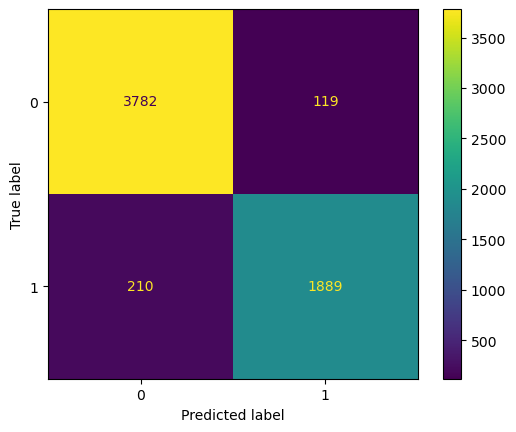

In [10]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

### Custom model of Fliptest paper

In [11]:
class Model:
    def predict(self, X):
        X = X[["work_exp", "hair_len"]].applymap(lambda i: i.mid).values
        return (np.dot(X, [1.4028, 1.1688]) > 0.8684).astype(int)

modelFliptest = Model()
modelFliptest.predict(X_test.iloc[:100, :])

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [12]:
positive_label = 1
negative_label = 0
preds = modelFliptest.predict(X)
print(classification_report(y.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80     13002
           1       0.63      0.53      0.58      6998

    accuracy                           0.73     20000
   macro avg       0.70      0.68      0.69     20000
weighted avg       0.72      0.73      0.72     20000



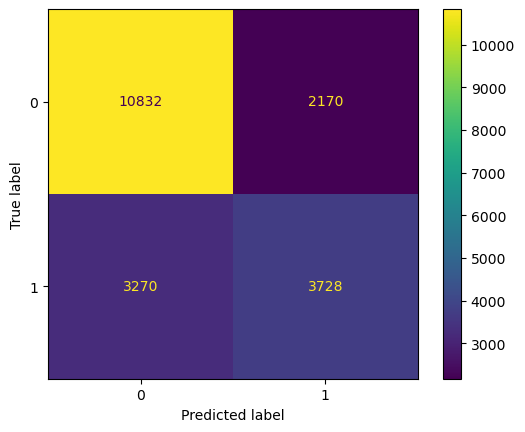

In [13]:
conf_matrix = confusion_matrix(y, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [14]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=modelFliptest,
     sensitive_attribute='gender',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.23it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 13512.58it/s]

Computing correctenesses for all valid if-thens.



100%|███████████████████████████████████████████████████████████████████████████████| 398/398 [00:03<00:00, 117.71it/s]

Number of if-thens: 398


In [15]:
# #### Uncomment if you wish to load rules object from disk

# import dill

# with open("rulesLipton.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [16]:
# #### Uncomment if you wish to save rules object on disk

# import dill

# with open("rulesLipton.data", "wb") as outf:
#      dill.dump(rules_by_if, outf)

In [17]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If hair_len = (-0.925, -0.7]:
	Subgroup 'Female', 5.82% covered
		Make hair_len = (1.516, 2.739] with correctness 78.51%.
		Make hair_len = (0.938, 1.516] with correctness 38.02%.
		Make hair_len = (0.471, 0.938] with correctness 28.93%.
		Make hair_len = (0.1, 0.471] with correctness 10.74%.
		Make hair_len = (-0.475, -0.205] with correctness 4.96%.
		Make hair_len = (-0.205, 0.1] with correctness 4.96%.
		Make hair_len = (-1.5659999999999998, -1.16] with correctness 0.00%.
		Make hair_len = (-1.16, -0.925] with correctness 0.00%.
		Make hair_len = (-0.7, -0.475] with correctness 0.00%.
	Subgroup 'Male', 18.31% covered
		Make hair_len = (1.516, 2.739] with correctness 98.01%.
		Make hair_len = (0.938, 1.516] with correctness 79.10%.
		Make hair_len = (0.471, 0.938] with correctness 70.65%.
		Make hair_len = (0.1, 0.471] with correctness 40.55%.
		Make hair_len = (-0.475, -0.205] with correctness 20.40%.
		Make hair_len = (-0.205, 0.1] with correctness 20.40%.
		Make hair_len = (-1.565

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [18]:
feature_weights = {"hair_len": 1, "work_exp": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [20]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 100
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If work_exp = (-3.1189999999999998, -1.276]:
	Subgroup 'Female', 25.02% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 83.85%.
		Make work_exp = (-0.0231, 0.193] with correctness 54.23%.
		Make work_exp = (0.193, 0.493] with correctness 54.23%.
		Make work_exp = (0.493, 0.824] with correctness 66.15%.
		Make work_exp = (-0.312, -0.0231] with correctness 37.12%.
		Make work_exp = (-1.276, -0.844] with correctness 20.38%.
		Make work_exp = (-0.844, -0.537] with correctness 20.38%.
		Make work_exp = (-0.537, -0.312] with correctness 20.38%.
		Aggregate cost of the above recourses = -0.51
	Subgroup 'Male', 3.73% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 40.24%.
		Make work_exp = (-0.0231, 0.193] with correctness 7.32%.
		Make work_exp = (0.193, 0.493] with correctness 7.32%.
		Make work_exp = (0.493, 0.824] with correctne

In [ ]:
shouldgive1 = pd.DataFrame({"hair_len": pd.Interval(1.516, 2.739), "work_exp": pd.Interval(-1.276, -0.844), 
modelFliptest.predict(

In [36]:
if1 = gfacts.Predicate.from_dict({"hair_len": pd.Interval(-0.475, -0.205), "work_exp": pd.Interval(-0.844, -0.537)})

print_recourse_report({if1: rules_by_if[if1]})

If hair_len = (-0.475, -0.205], work_exp = (-0.844, -0.537]:
	Subgroup 'Female', 1.68% covered
		Make hair_len = (1.516, 2.739], work_exp = (-1.276, -0.844] with correctness 100.00%.
		Make hair_len = (1.516, 2.739] with correctness 100.00%.
		Make hair_len = (-1.5659999999999998, -1.16], work_exp = (1.311, 3.896] with correctness 100.00%.
		Make hair_len = (-1.16, -0.925], work_exp = (1.311, 3.896] with correctness 100.00%.
		Make hair_len = (1.516, 2.739], work_exp = (-0.537, -0.312] with correctness 100.00%.
		Make hair_len = (-0.7, -0.475], work_exp = (1.311, 3.896] with correctness 100.00%.
		Make hair_len = (-0.925, -0.7], work_exp = (1.311, 3.896] with correctness 100.00%.
		Make hair_len = (1.516, 2.739], work_exp = (-0.0231, 0.193] with correctness 100.00%.
		Make hair_len = (1.516, 2.739], work_exp = (-0.312, -0.0231] with correctness 100.00%.
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 100.00%.
		Make hair_len 

In [ ]:
hair_len = (-0.475, -0.205], work_exp = (-0.844, -0.537]

In [30]:
X_test.value_counts()[pd.Interval(-0.844, -0.537)]

hair_len                      gender
(1.516, 2.739]                Female    89
(0.938, 1.516]                Female    82
(0.1, 0.471]                  Female    61
(0.471, 0.938]                Female    58
(-0.205, 0.1]                 Female    44
(-0.475, -0.205]              Female    35
(-1.5659999999999998, -1.16]  Male      34
(-0.7, -0.475]                Female    30
(-0.475, -0.205]              Male      29
(-0.925, -0.7]                Male      24
(-1.16, -0.925]               Male      24
(-0.7, -0.475]                Male      21
(-1.16, -0.925]               Female    20
(-0.205, 0.1]                 Male      18
(-0.925, -0.7]                Female    18
(0.1, 0.471]                  Male      10
(0.471, 0.938]                Male      10
(-1.5659999999999998, -1.16]  Female     8
(0.938, 1.516]                Male       3
dtype: int64

## Minimum cost above threshold

In [20]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

With the given parameters, no recourses showing unfairness have been found!



## Mean cost above threshold

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

With the given parameters, no recourses showing unfairness have been found!



## Number above threshold

In [22]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If work_exp = (-3.1189999999999998, -1.276]:
	Subgroup 'Female', 25.02% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 83.85%.
		Make work_exp = (-0.0231, 0.193] with correctness 54.23%.
		Make work_exp = (0.193, 0.493] with correctness 54.23%.
		Make work_exp = (0.493, 0.824] with correctness 66.15%.
		Aggregate cost of the above recourses = -5.00
	Subgroup 'Male', 3.73% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Aggregate cost of the above recourses = -1.00
	Bias against Male. Unfairness measure = 4.
If work_exp = (-1.276, -0.844]:
	Subgroup 'Female', 19.30% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 82.04%.
		Make work_exp = (0.493, 0.824] with correctness 61.85%.
		Aggregate cost of the above recourses = -3.00
	Subgroup 'Male', 6.15% covered out of 10000
		Make work_exp = (1.3

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [23]:
import dill

with open("stateLipton.data", "rb") as inf:
    rules_by_if, modelFliptest, X_test = dill.load(inf)

If work_exp = (-3.1189999999999998, -1.276]:
	Subgroup 'Female', 25.02% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 83.85%.
		Make work_exp = (-0.0231, 0.193] with correctness 54.23%.
		Make work_exp = (0.193, 0.493] with correctness 54.23%.
		Make work_exp = (0.493, 0.824] with correctness 66.15%.
		Make work_exp = (-0.312, -0.0231] with correctness 37.12%.
		Make work_exp = (-1.276, -0.844] with correctness 20.38%.
		Make work_exp = (-0.844, -0.537] with correctness 20.38%.
		Make work_exp = (-0.537, -0.312] with correctness 20.38%.
	Subgroup 'Male', 3.73% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 40.24%.
		Make work_exp = (-0.0231, 0.193] with correctness 7.32%.
		Make work_exp = (0.193, 0.493] with correctness 7.32%.
		Make work_exp = (0.493, 0.824] with correctness 14.63%.
		Make work_exp = (-0.312, -0.0231] w

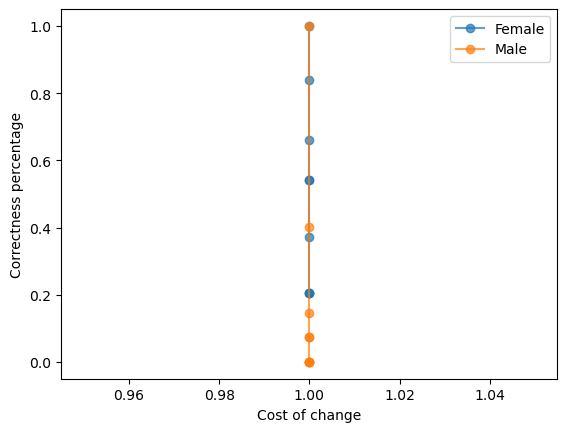

If work_exp = (-1.276, -0.844]:
	Subgroup 'Female', 19.30% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 82.04%.
		Make work_exp = (-0.0231, 0.193] with correctness 45.64%.
		Make work_exp = (0.193, 0.493] with correctness 45.64%.
		Make work_exp = (0.493, 0.824] with correctness 61.85%.
		Make work_exp = (-0.312, -0.0231] with correctness 25.44%.
		Make work_exp = (-0.844, -0.537] with correctness 0.00%.
		Make work_exp = (-0.537, -0.312] with correctness 0.00%.
	Subgroup 'Male', 6.15% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 37.04%.
		Make work_exp = (-0.0231, 0.193] with correctness 5.19%.
		Make work_exp = (0.193, 0.493] with correctness 5.19%.
		Make work_exp = (0.493, 0.824] with correctness 13.33%.
		Make work_exp = (-0.312, -0.0231] with correctness 1.48%.
		Make work_exp = (-0.844, -0.537] with correctness 

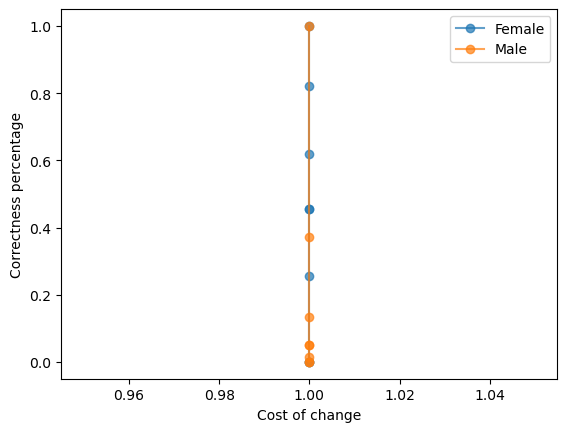

If work_exp = (-0.537, -0.312]:
	Subgroup 'Female', 14.44% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 79.33%.
		Make work_exp = (-0.0231, 0.193] with correctness 44.00%.
		Make work_exp = (0.193, 0.493] with correctness 44.00%.
		Make work_exp = (0.493, 0.824] with correctness 59.67%.
		Make work_exp = (-0.312, -0.0231] with correctness 23.67%.
		Make work_exp = (-1.276, -0.844] with correctness 0.00%.
		Make work_exp = (-0.844, -0.537] with correctness 0.00%.
	Subgroup 'Male', 9.15% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 41.29%.
		Make work_exp = (-0.0231, 0.193] with correctness 5.47%.
		Make work_exp = (0.193, 0.493] with correctness 5.47%.
		Make work_exp = (0.493, 0.824] with correctness 14.93%.
		Make work_exp = (-0.312, -0.0231] with correctness 1.99%.
		Make work_exp = (-1.276, -0.844] with correctness 

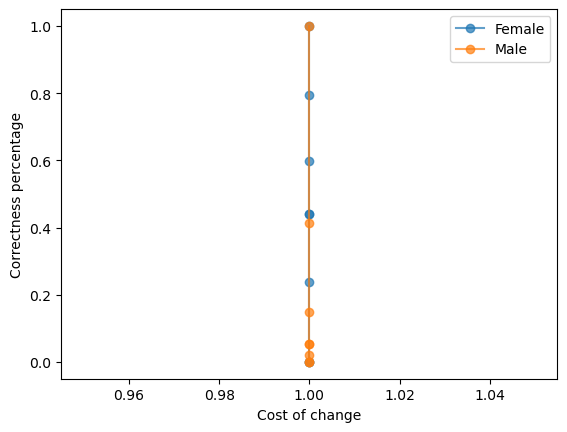

If work_exp = (-0.844, -0.537]:
	Subgroup 'Female', 17.13% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 78.65%.
		Make work_exp = (-0.0231, 0.193] with correctness 39.33%.
		Make work_exp = (0.193, 0.493] with correctness 39.33%.
		Make work_exp = (0.493, 0.824] with correctness 56.46%.
		Make work_exp = (-0.312, -0.0231] with correctness 23.03%.
		Make work_exp = (-1.276, -0.844] with correctness 0.00%.
		Make work_exp = (-0.537, -0.312] with correctness 0.00%.
	Subgroup 'Male', 7.88% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 40.46%.
		Make work_exp = (-0.0231, 0.193] with correctness 7.51%.
		Make work_exp = (0.193, 0.493] with correctness 7.51%.
		Make work_exp = (0.493, 0.824] with correctness 13.29%.
		Make work_exp = (-0.312, -0.0231] with correctness 1.73%.
		Make work_exp = (-1.276, -0.844] with correctness 

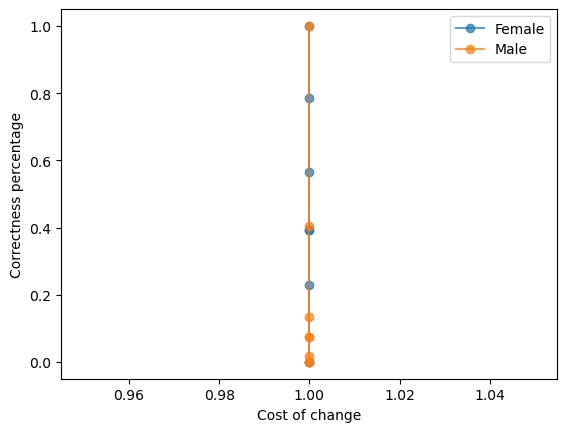

If hair_len = (-0.925, -0.7]:
	Subgroup 'Female', 5.82% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 78.51%.
		Make hair_len = (0.938, 1.516] with correctness 38.02%.
		Make hair_len = (0.471, 0.938] with correctness 28.93%.
		Make hair_len = (0.1, 0.471] with correctness 10.74%.
		Make hair_len = (-0.475, -0.205] with correctness 4.96%.
		Make hair_len = (-0.205, 0.1] with correctness 4.96%.
		Make hair_len = (-1.5659999999999998, -1.16] with correctness 0.00%.
		Make hair_len = (-1.16, -0.925] with correctness 0.00%.
		Make hair_len = (-0.7, -0.475] with correctness 0.00%.
	Subgroup 'Male', 18.31% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 98.01%.
		Make hair_len = (0.938, 1.516] with correctness 79.10%.
		Make hair_len = (0.471, 0.938] with correctness 70.65%.
		Make hair_len = (0.1, 0.471] with correctness 40.55%.
		Make hair_len = (-0.475, -0.205] with correctness 20.40%.
		Make hair_len = (-0.205, 0.1] with correctness 20.40%.

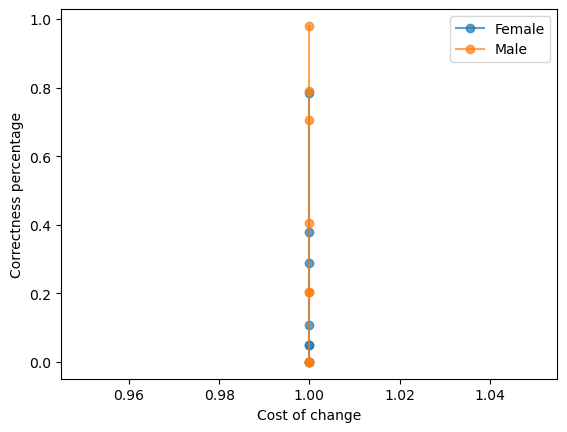

If hair_len = (-1.16, -0.925]:
	Subgroup 'Female', 5.05% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 80.95%.
		Make hair_len = (0.938, 1.516] with correctness 33.33%.
		Make hair_len = (0.471, 0.938] with correctness 25.71%.
		Make hair_len = (0.1, 0.471] with correctness 11.43%.
		Make hair_len = (-0.475, -0.205] with correctness 3.81%.
		Make hair_len = (-0.205, 0.1] with correctness 3.81%.
		Make hair_len = (-1.5659999999999998, -1.16] with correctness 0.00%.
		Make hair_len = (-0.925, -0.7] with correctness 0.00%.
		Make hair_len = (-0.7, -0.475] with correctness 0.00%.
	Subgroup 'Male', 18.44% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 96.79%.
		Make hair_len = (0.938, 1.516] with correctness 77.28%.
		Make hair_len = (0.471, 0.938] with correctness 67.65%.
		Make hair_len = (0.1, 0.471] with correctness 38.27%.
		Make hair_len = (-0.475, -0.205] with correctness 20.74%.
		Make hair_len = (-0.205, 0.1] with correctness 20.74%.

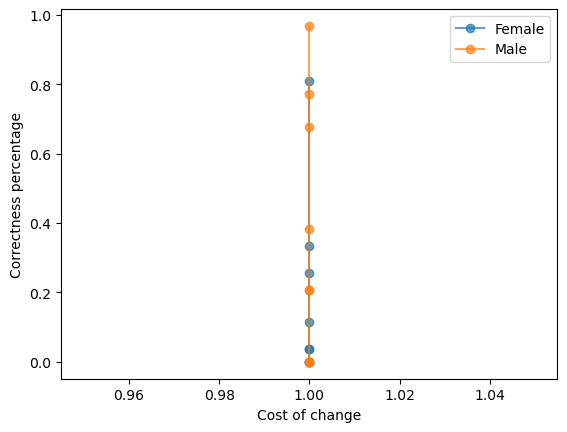

If hair_len = (-0.7, -0.475]:
	Subgroup 'Female', 7.89% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 84.15%.
		Make hair_len = (0.938, 1.516] with correctness 36.59%.
		Make hair_len = (0.471, 0.938] with correctness 26.83%.
		Make hair_len = (0.1, 0.471] with correctness 12.20%.
		Make hair_len = (-0.475, -0.205] with correctness 1.83%.
		Make hair_len = (-0.205, 0.1] with correctness 1.83%.
		Make hair_len = (-1.5659999999999998, -1.16] with correctness 0.00%.
		Make hair_len = (-1.16, -0.925] with correctness 0.00%.
		Make hair_len = (-0.925, -0.7] with correctness 0.00%.
	Subgroup 'Male', 16.58% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 95.33%.
		Make hair_len = (0.938, 1.516] with correctness 76.92%.
		Make hair_len = (0.471, 0.938] with correctness 65.11%.
		Make hair_len = (0.1, 0.471] with correctness 37.09%.
		Make hair_len = (-0.475, -0.205] with correctness 18.41%.
		Make hair_len = (-0.205, 0.1] with correctness 18.41%.

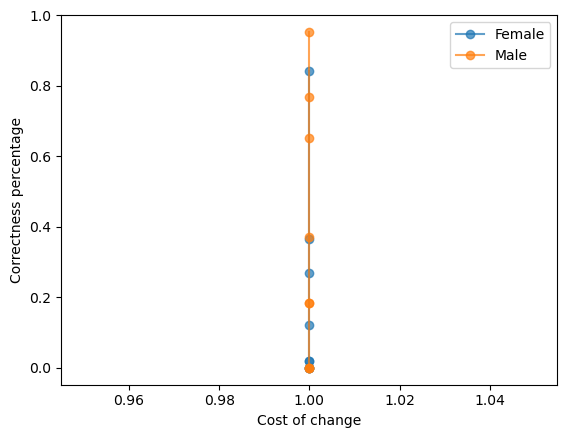

If work_exp = (-0.312, -0.0231]:
	Subgroup 'Female', 9.14% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 75.79%.
		Make work_exp = (-0.0231, 0.193] with correctness 26.84%.
		Make work_exp = (0.193, 0.493] with correctness 26.84%.
		Make work_exp = (0.493, 0.824] with correctness 47.89%.
		Make work_exp = (-1.276, -0.844] with correctness 0.00%.
		Make work_exp = (-0.844, -0.537] with correctness 0.00%.
		Make work_exp = (-0.537, -0.312] with correctness 0.00%.
	Subgroup 'Male', 12.30% covered out of 10000
		Make work_exp = (1.311, 3.896] with correctness 100.00%.
		Make work_exp = (0.824, 1.311] with correctness 33.70%.
		Make work_exp = (-0.0231, 0.193] with correctness 3.33%.
		Make work_exp = (0.193, 0.493] with correctness 3.33%.
		Make work_exp = (0.493, 0.824] with correctness 11.11%.
		Make work_exp = (-1.276, -0.844] with correctness 0.00%.
		Make work_exp = (-0.844, -0.537] with correctness 0.

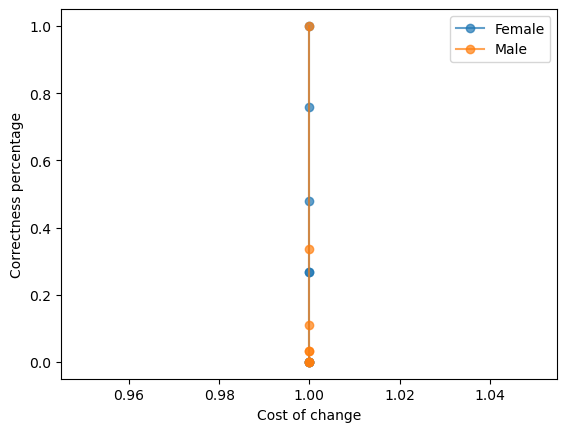

If hair_len = (-1.5659999999999998, -1.16]:
	Subgroup 'Female', 3.85% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 85.00%.
		Make hair_len = (0.938, 1.516] with correctness 43.75%.
		Make hair_len = (0.471, 0.938] with correctness 30.00%.
		Make hair_len = (0.1, 0.471] with correctness 10.00%.
		Make hair_len = (-0.475, -0.205] with correctness 5.00%.
		Make hair_len = (-0.205, 0.1] with correctness 5.00%.
		Make hair_len = (-1.16, -0.925] with correctness 0.00%.
		Make hair_len = (-0.925, -0.7] with correctness 0.00%.
		Make hair_len = (-0.7, -0.475] with correctness 0.00%.
	Subgroup 'Male', 19.40% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 97.42%.
		Make hair_len = (0.938, 1.516] with correctness 77.70%.
		Make hair_len = (0.471, 0.938] with correctness 62.91%.
		Make hair_len = (0.1, 0.471] with correctness 36.85%.
		Make hair_len = (-0.475, -0.205] with correctness 18.54%.
		Make hair_len = (-0.205, 0.1] with correctness 18.54%.

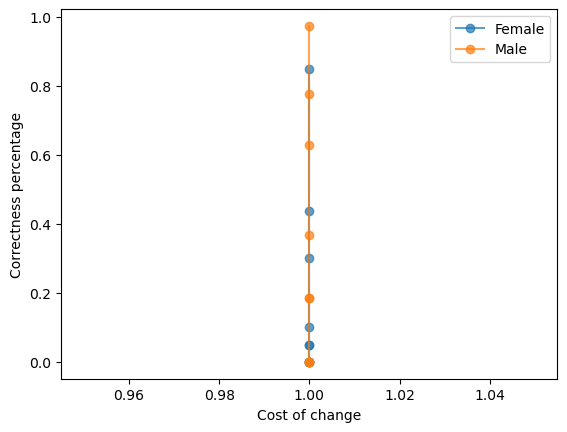

If hair_len = (-0.475, -0.205]:
	Subgroup 'Female', 10.30% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 80.37%.
		Make hair_len = (0.938, 1.516] with correctness 35.51%.
		Make hair_len = (0.471, 0.938] with correctness 23.36%.
		Make hair_len = (0.1, 0.471] with correctness 7.48%.
		Make hair_len = (-0.205, 0.1] with correctness 0.00%.
		Make hair_len = (-1.5659999999999998, -1.16] with correctness 0.00%.
		Make hair_len = (-1.16, -0.925] with correctness 0.00%.
		Make hair_len = (-0.925, -0.7] with correctness 0.00%.
		Make hair_len = (-0.7, -0.475] with correctness 0.00%.
	Subgroup 'Male', 12.34% covered out of 10000
		Make hair_len = (1.516, 2.739] with correctness 95.94%.
		Make hair_len = (0.938, 1.516] with correctness 68.27%.
		Make hair_len = (0.471, 0.938] with correctness 53.14%.
		Make hair_len = (0.1, 0.471] with correctness 20.66%.
		Make hair_len = (-0.205, 0.1] with correctness 0.00%.
		Make hair_len = (-1.5659999999999998, -1.16] with correctn

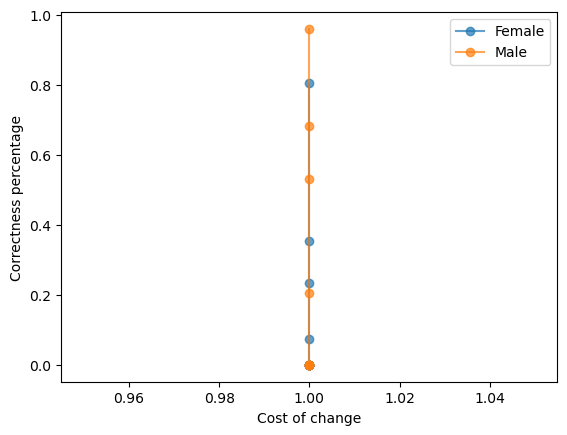

In [24]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, modelFliptest, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (X[sensitive_attribute] == sg).sum() for sg in X[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [25]:
import dill

with open("stateLipton.data", "wb") as outf:
    dill.dump((rules_by_if, modelFliptest, X_test), outf)